In [32]:
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import rasterio
from tile_mate import get_raster_from_tiles, DATASET_SHORTNAMES
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np

# Parameters

In [33]:
EVENT_NAME = 'chile_fire_2024'

# Read Yaml

In [34]:
yaml_file = f'events/{EVENT_NAME}.yml' #'porto_algre.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

In [3]:
water_mask_dir = Path(f'out/{event_dict['event_name']}/water_mask')
water_mask_dir.mkdir(exist_ok=True, parents=True)

In [4]:
change_dir_hls = Path('out') / event_dict['event_name'] / 'change_map_dist_hls'
change_dir_hls.mkdir(exist_ok=True, parents=True)
change_map_tif = list(change_dir_hls.glob('*.tif'))[0]

In [5]:
with rasterio.open(change_map_tif) as ds:
    ref_profile = ds.profile
    ref_crs = ds.crs
    ref_bounds = ds.bounds

In [6]:
bounds_4326 = transform_bounds(ref_profile['crs'], CRS.from_epsg(4326), *ref_bounds)

In [7]:
X_esa, p_esa = get_raster_from_tiles(bounds_4326, tile_shortname='esa_world_cover_2021')

Reading tile metadata: 100%|█| 3/3 [00:00<00:00, 145
Reading tile imagery: 100%|█| 3/3 [00:03<00:00,  1.3


In [8]:
X_pekel, p_pekel = get_raster_from_tiles(bounds_4326, tile_shortname='pekel_water_occ_2021')

Reading tile metadata: 100%|█| 1/1 [00:00<00:00, 105
Reading tile imagery: 100%|█| 1/1 [00:01<00:00,  1.0


In [9]:
l = X_esa[0, :, 0]
l = l[~np.isin(l, [60, 80])]
l

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

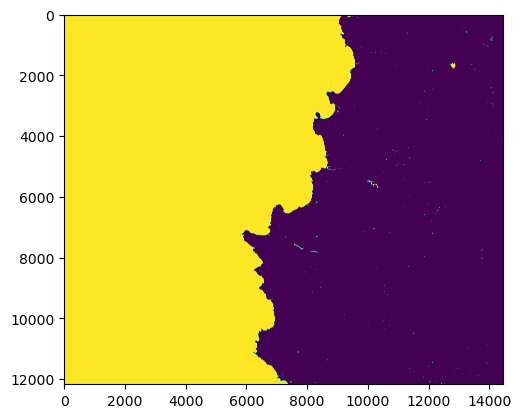

In [10]:
X_esa_water = (np.isin(X_esa, [0, 80]))[0, ...]
plt.imshow(X_esa_water)

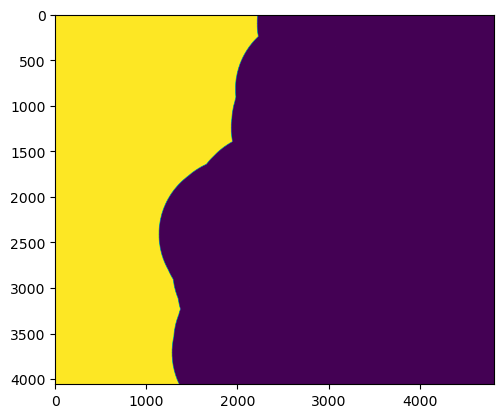

In [11]:
X_pekel_water = (X_pekel > 99)[0, ...]
plt.imshow(X_pekel_water)

In [17]:
X_glad_2020, p_glad = get_raster_from_tiles(bounds_4326, tile_shortname='glad_landcover', year=2020)

Reading tile metadata: 100%|█| 1/1 [00:00<00:00, 112
Reading tile imagery: 100%|█| 1/1 [00:02<00:00,  2.5


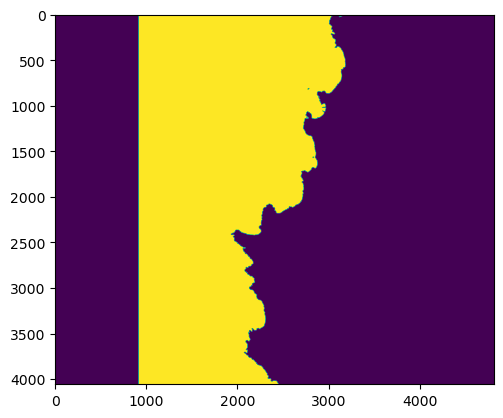

In [22]:
X_glad_water = (X_glad_2020 == 254).astype(np.uint8)[0, ...]
plt.imshow(X_glad_water)

# Reproject everything

In [23]:
src_profile = p_pekel.copy()
src_profile['dtype'] = np.uint8
src_profile['nodata'] = 255

X_p_r, p_pekel_r = reproject_arr_to_match_profile(X_pekel_water.astype(np.uint8), src_profile, ref_profile, resampling='nearest')

In [24]:
src_profile = p_glad.copy()
src_profile['dtype'] = np.uint8
src_profile['nodata'] = 255

X_glad_water_r, p_glad_r = reproject_arr_to_match_profile(X_glad_water.astype(np.uint8), src_profile, ref_profile, resampling='nearest')

In [25]:
src_profile = p_esa.copy()
src_profile['dtype'] = np.float32
src_profile['nodata'] = np.nan

X_esa_r, p_esa_r = reproject_arr_to_match_profile(X_esa_water.astype(np.float32), src_profile, ref_profile, resampling='average')

In [26]:
X_esa_water_r = (X_esa_r > .5).astype(np.uint8)

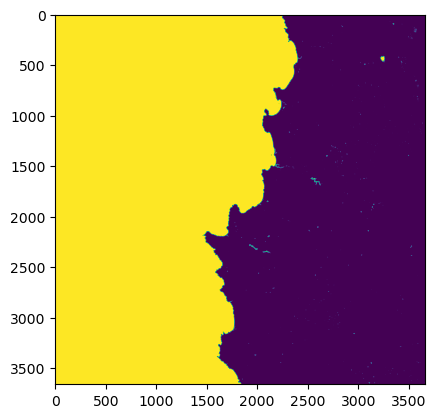

In [28]:
X_water_final = X_esa_water_r | X_p_r | X_glad_water_r

plt.imshow(X_water_final[0, ...])

In [29]:
with rasterio.open(water_mask_dir / 'water_mask.tif', 'w', **p_esa_r) as ds:
    ds.write(X_water_final)